### Single Structure object

In [2]:
from util.math import GaussianDistance
from pymatgen.core.structure import Structure
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

##### radial function test

In [76]:
crys = Structure.from_file('C:/WORKSPACE_KRICT/DATA/data_snu/with_metal/source/POSCAR_ICSD-1')

atomic_numbers = crys.atomic_numbers
element = [52, 24, 8] #list(set(atomic_numbers))
map_element = [element.index(an) for an in atomic_numbers]
all_nbrs = crys.get_all_neighbors(8, include_index=True)

dists = {i:None for i in range(len(atomic_numbers))}
for i, nbrs in enumerate(all_nbrs):
    rs = {j:list() for j in range(len(element))}
    for nbr in nbrs:
        r, j = nbr[1:3]
        ej = map_element[j]
        rs[ej].append(r)
    dists[i] = rs

In [78]:
def calc_rdf_d(dists, rmax=8, dr=0.1, norm=True):
    x = np.arange(0, rmax, dr)
    div = 1/(x + 1e-6)**2
    y1 = len(dists)
    y2 = len(dists[0])
    y = np.zeros((y1, y2, x.shape[0]), dtype=float)
    ylbl = []
    for i, dist in dists.items():
        for j, rs in dist.items():
            for r in rs:
                if r > rmax: continue
                iy = int(r/dr)
                y[i, j, iy] += 1
            ylbl.append(f'ele{i+1}-ele{j+1}')
    if norm: y = y*div
    return x, y.reshape(-1,x.shape[0]), ylbl

def calc_rdf_g(dists, rmax=8, dr=0.1, norm=True, var=0.05):
    gd = GaussianDistance(dmin=0, dmax=rmax, step=dr, var=var)
    x = gd.filter
    div = 1/(x+1e-6)**2
    y1 = len(dists)
    y2 = len(dists[0])
    y = np.zeros((y1, y2, x.shape[0]), dtype=float)
    ylbl = []
    for i, dist in dists.items():
        for j, rs in dist.items():
            y[i, j] = np.sum(gd.expand(np.array(rs)), axis=0)
            ylbl.append(f'ele{i+1}-ele{j+1}')
    if norm: y = y*div
    return x, y.reshape(-1,x.shape[0]), ylbl

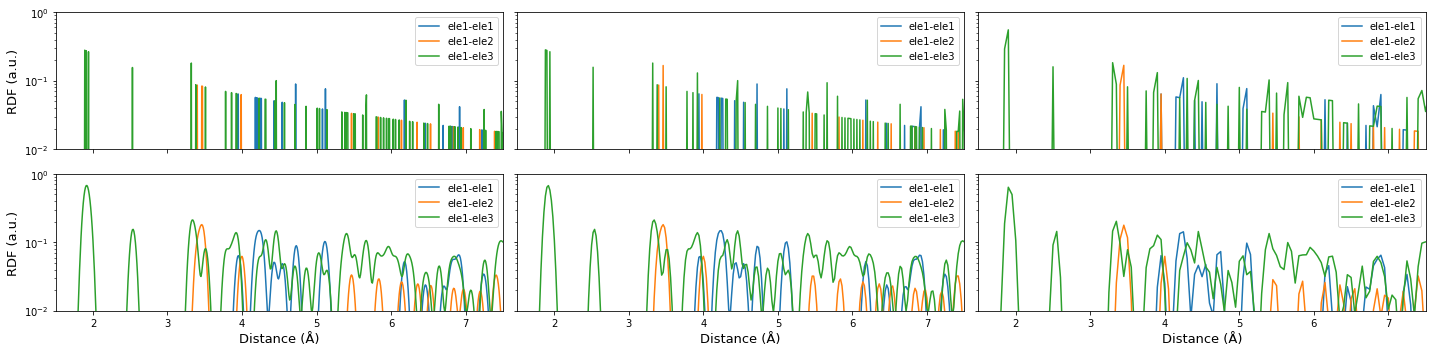

In [79]:
f, axs = plt.subplots(2, 3, figsize=(20,5))
for i, dr in enumerate([0.01, 0.02, 0.05]):
    x, ys, ylbls = calc_rdf_d(dists, dr=dr)
    for y, ylbl in zip(ys[:3], ylbls[:3]):
        axs[0,i].plot(x, y + 1e-6, label=ylbl)
    x, ys, ylbls = calc_rdf_g(dists, dr=dr, var=0.05)
    for y, ylbl in zip(ys[:3], ylbls[:3]):
        axs[1,i].plot(x, y + 1e-6, label=ylbl)

for ax in axs.reshape(-1):
    ax.legend()
    ax.set_yscale('log')
    ax.set_xlim([1.5,7.5])
    ax.set_ylim([0.01, 1])
for ax in axs[0]:
    ax.set_xticklabels([])
for ax in axs[1]:
    ax.set_xlabel('Distance (Å)', fontsize=13)
for ax in axs[:,0]:
    ax.set_ylabel('RDF (a.u.)', fontsize=13)
for ax in axs[:,1:].reshape(-1):
    ax.set_yticklabels([])
plt.tight_layout()


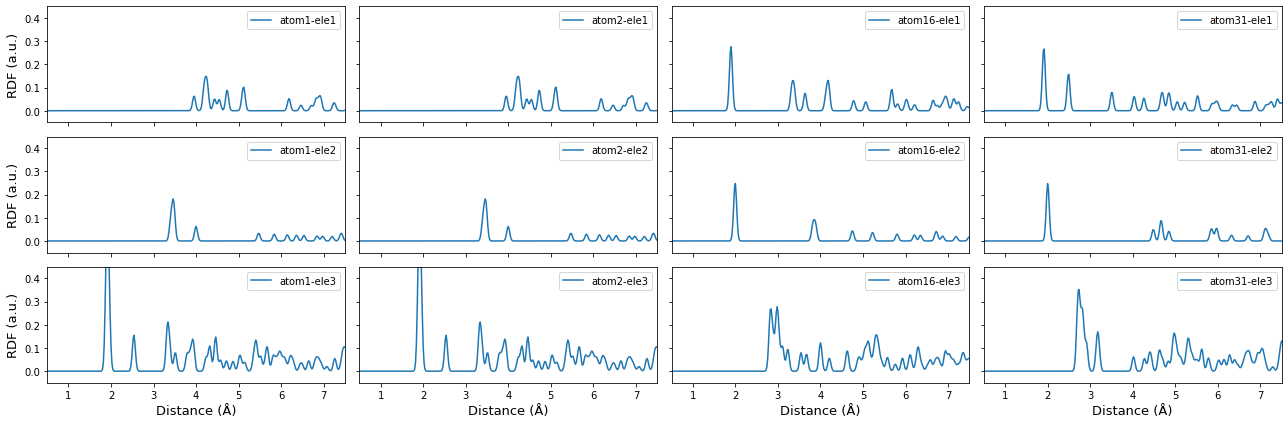

In [87]:
idxs = [0, 1, 15 , 30]
f, axs = plt.subplots(3, len(idxs), figsize=(18,6))

x, ys, ylbls = calc_rdf_g(dists, dr=0.02, var=0.05)
ys = ys.reshape(-1, 3, x.shape[0])
for i,idx in enumerate(idxs):
    for j in range(3):
        axs[j,i].plot(x, ys[idx,j], label=f'atom{idx+1}-ele{j+1}')
        axs[j,i].legend()
        axs[j,i].set_xlim([0.5,7.5])
        axs[j,i].set_ylim([-0.05, 0.45])

for ax in axs[:-1].reshape(-1):
    ax.set_xticklabels([])
for ax in axs[-1,:].reshape(-1):
    ax.set_xlabel('Distance (Å)', fontsize=13)
for ax in axs[:,0].reshape(-1):
    ax.set_ylabel('RDF (a.u.)', fontsize=13)
for ax in axs[:,1:].reshape(-1):
    ax.set_yticklabels([])
plt.tight_layout()


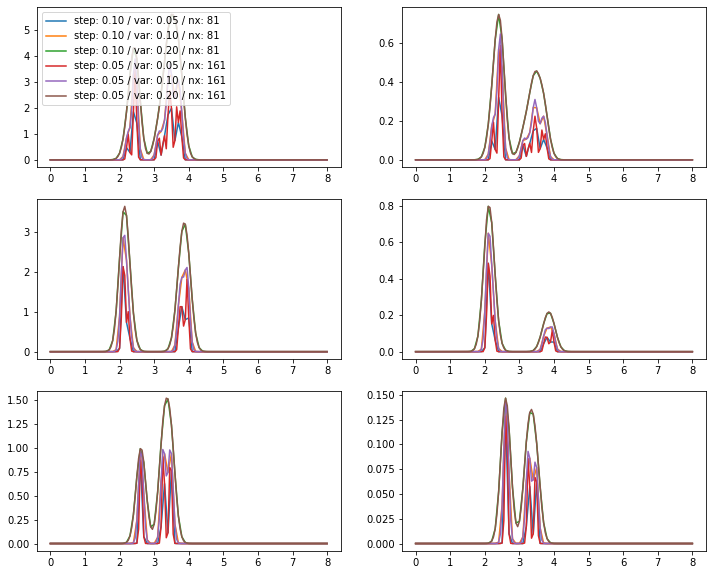

In [61]:

f, ax = plt.subplots(3, 2, figsize=(12,10))

for step, var in zip([0.1, 0.1, 0.1, 0.05, 0.05, 0.05], [0.05, 0.1, 0.2, 0.05, 0.1, 0.2]):
    x, output = fn(step, var)
    label = 'step: {:.2f} / var: {:.2f} / nx: {:2d}'.format(step, var, len(x))
    for i, (y, yv) in output.items():
        ax[i, 0].plot(x, y, label=label)
        ax[i, 1].plot(x, yv)
ax[0, 0].legend(loc='upper left')

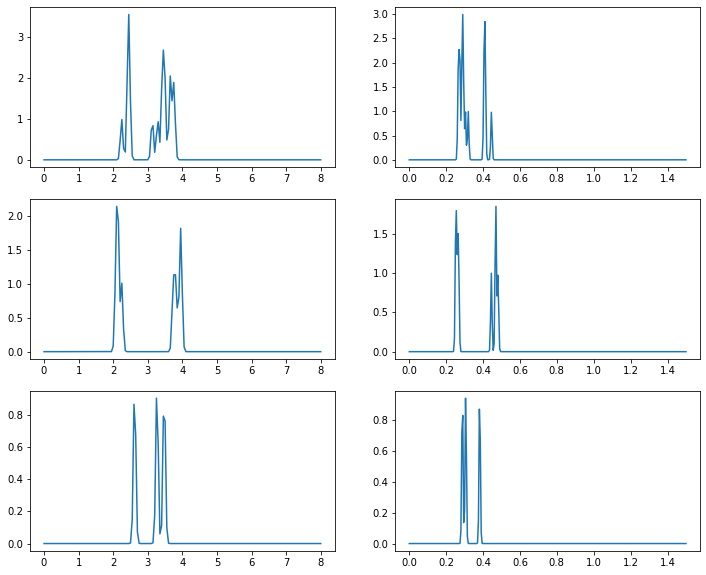

In [69]:
f, axs = plt.subplots(3, 2, figsize=(12,10))

irgd = GaussianDistance(dmin=0, dmax=1.5, step=0.005)
rgd = GaussianDistance(dmin=0, dmax=8, step=0.05)

ix = irgd.filter
x = rgd.filter
for i, ax in enumerate(axs):
    y  = np.sum(rgd.expand(np.array(rs[i])), axis=0)
    iy = np.sum(irgd.expand(np.array(irs[i])), axis=0)
    ax[0].plot(x, y)
    ax[1].plot(ix, iy)

##### angular function test

In [46]:
def w_bdf_m1(r):
    r = np.array(r)
    cut = 2
    max = 5
    out = -(r-cut)/(max-cut) +1
    out[out > 1] = 1
    out[out < 1e-3] = 0
    return out

def w_bdf_m2(r):
    r = np.array(r)
    out = 1/r
    out[out > 1] = 1
    out[out < 1e-3] = 0
    return out

def w_bdf_m3(r):
    r = np.array(r)
    out = 1/r**2
    out[out > 1] = 1
    out[out < 1e-3] = 0
    return out

In [39]:
import time
from nm.util.math import angle, angle_v, GaussianDistance
import numpy as np

step = 0.02

atomic_numbers = np.array(crys.atomic_numbers) - 1
element = sorted(set(atomic_numbers))
map_element = [element.index(an) for an in atomic_numbers]
bgd = GaussianDistance(dmin=0, dmax=3.15, step=step, var = 0.02)

def by_mat1(all_nbrs):
    t1 = time.time()
    bdf_feature = np.zeros((0, bgd.filter.shape[0]))
#    all_data = np.zeros((0,3))
#    all_vecs = np.zeros((0,2,3))
    for i, nbrs in enumerate(all_nbrs):
        c = crys[i].coords
        data = []
        vecs = []
        for j, nbr_j in enumerate(nbrs):
            v1 = nbr_j[0].coords - c
            rj = nbr_j[1]
            ij = map_element[nbr_j[2]]

            for k, nbr_k in enumerate(nbrs):
                if j == k: continue
                v2 = nbr_k[0].coords - c
                rk = nbr_k[1]
                ik = map_element[nbr_k[2]]
                r = (rj + rk)*0.5
                data.append([ij, ik, r])
                vecs.append([v1, v2])
        ij, ik, r = np.array(data).T
        vecs = np.array(vecs)
        a = bgd.expand(angle_v(vecs[:,0,:], vecs[:,1,:])).squeeze()
        w = w_bdf_m1(r).reshape(-1,1)
        bdf = a*w
        for j in range(len(element)):
            bdf_feature = np.vstack([
                bdf_feature, 
                np.sum(bdf[ij == j], axis=0) + np.sum(bdf[ik == j], axis=0)
            ])
    t = time.time() - t1
    return bdf_feature, t


def by_mat2(all_nbrs):
    t1 = time.time()
    bdf_feature = np.zeros((0, bgd.filter.shape[0]))
#    all_data = np.zeros((0,3))
#    all_vecs = np.zeros((0,2,3))
    for i, nbrs in enumerate(all_nbrs):
        c = crys[i].coords
        data = []
        vecs = []
        for j, nbr_j in enumerate(nbrs):
            v1 = nbr_j[0].coords - c
            rj = nbr_j[1]
            ij = map_element[nbr_j[2]]

            for k, nbr_k in enumerate(nbrs):
                if j == k: continue
                v2 = nbr_k[0].coords - c
                rk = nbr_k[1]
                ik = map_element[nbr_k[2]]
                r = rj + rk
                data.append([ij, ik, r])
                vecs.append([v1, v2])
        ij, ik, r = np.array(data).T
        vecs = np.array(vecs)
        a = bgd.expand(angle_v(vecs[:,0,:], vecs[:,1,:])).squeeze()
        w = w_bdf_m2(r).reshape(-1,1)
        bdf = a*w
        for j in range(len(element)):
            bdf_feature = np.vstack([
                bdf_feature, 
                np.sum(bdf[ij == j], axis=0) + np.sum(bdf[ik == j], axis=0)
            ])
    t = time.time() - t1
    return bdf_feature, t

    
def by_mat3(all_nbrs):
    t1 = time.time()
    bdf_feature = np.zeros((0, bgd.filter.shape[0]))
#    all_data = np.zeros((0,3))
#    all_vecs = np.zeros((0,2,3))
    for i, nbrs in enumerate(all_nbrs):
        c = crys[i].coords
        data = []
        vecs = []
        for j, nbr_j in enumerate(nbrs):
            v1 = nbr_j[0].coords - c
            rj = nbr_j[1]
            ij = map_element[nbr_j[2]]

            for k, nbr_k in enumerate(nbrs):
                if j == k: continue
                v2 = nbr_k[0].coords - c
                rk = nbr_k[1]
                ik = map_element[nbr_k[2]]
                r = rj**3 + rk**3
                data.append([ij, ik, r])
                vecs.append([v1, v2])
        ij, ik, r = np.array(data).T
        vecs = np.array(vecs)
        a = bgd.expand(angle_v(vecs[:,0,:], vecs[:,1,:])).squeeze()
        w = w_bdf_m2(r).reshape(-1,1)
        bdf = a*w
        for j in range(len(element)):
            bdf_feature = np.vstack([
                bdf_feature, 
                np.sum(bdf[ij == j], axis=0) + np.sum(bdf[ik == j], axis=0)
            ])
    t = time.time() - t1
    return bdf_feature, t

In [44]:
nbr = crys.get_all_neighbors(4.5, include_index=True)

In [47]:
n = 15
ts = []
for i in range(n):
    bdfm1, t = by_mat1(nbr)
    ts.append(t)
print('avg: {:.3f} / var: {:.3f} / min: {:.3f} / max: {:.3f}'.format(np.mean(ts), np.var(ts), np.min(ts), np.max(ts)))

ts = []
for i in range(n):
    bdfm2, t = by_mat2(nbr)
    ts.append(t)
print('avg: {:.3f} / var: {:.3f} / min: {:.3f} / max: {:.3f}'.format(np.mean(ts), np.var(ts), np.min(ts), np.max(ts)))

ts = []
for i in range(n):
    bdfm3, t = by_mat3(nbr)
    ts.append(t)
print('avg: {:.3f} / var: {:.3f} / min: {:.3f} / max: {:.3f}'.format(np.mean(ts), np.var(ts), np.min(ts), np.max(ts)))


avg: 1.510 / var: 0.006 / min: 1.419 / max: 1.613
avg: 1.485 / var: 0.006 / min: 1.404 / max: 1.594
avg: 1.564 / var: 0.006 / min: 1.486 / max: 1.674


0.855 sec
2.393 sec
12.743 sec


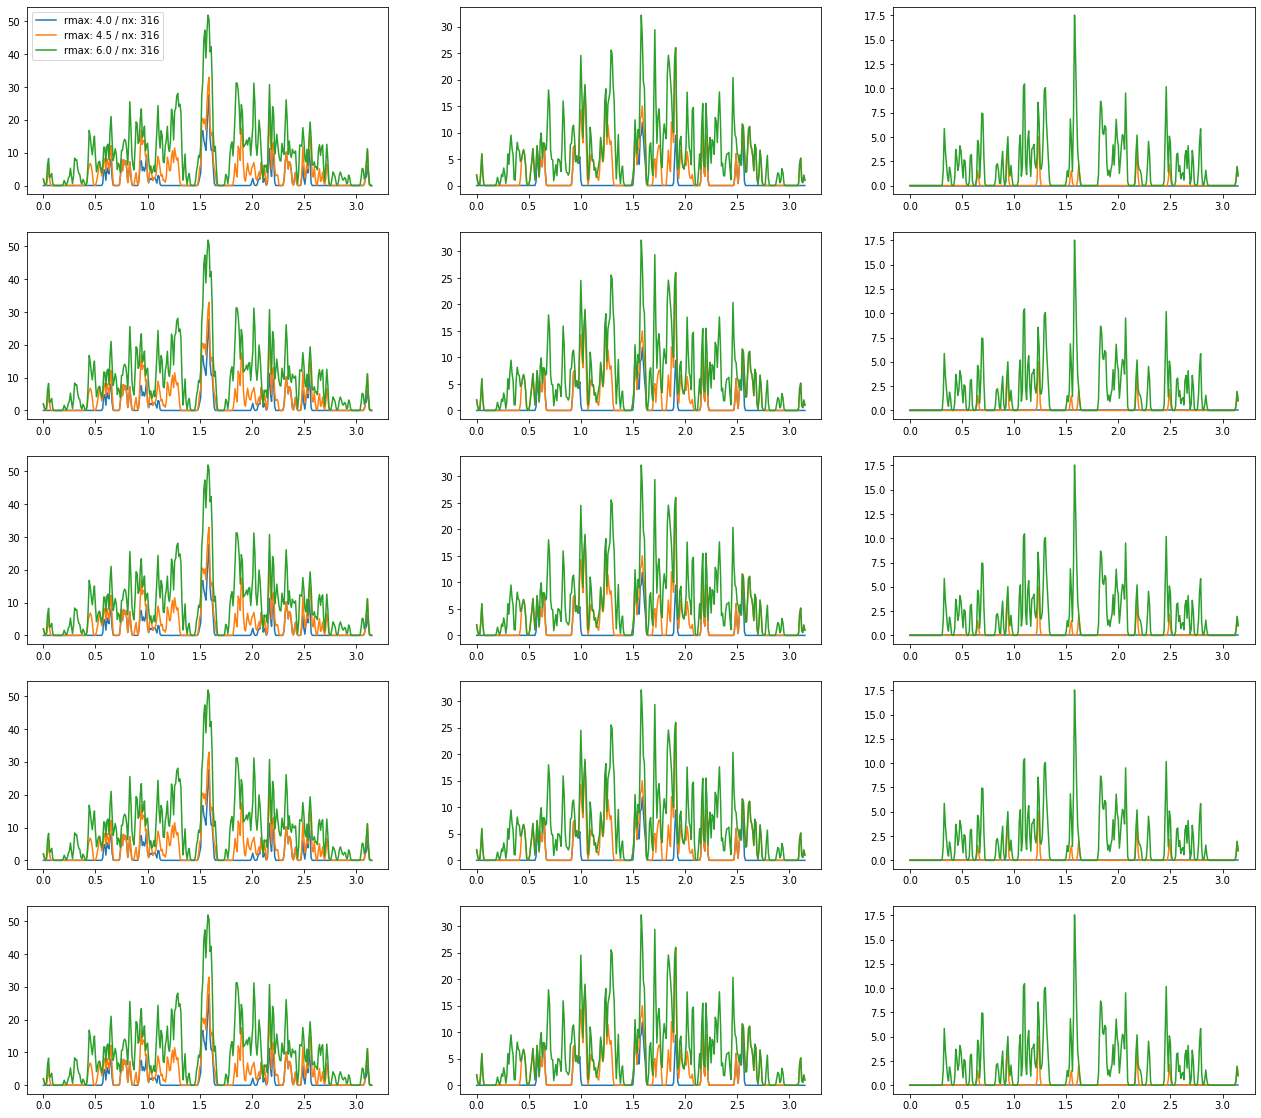

In [ ]:
f, ax = plt.subplots(5, 3, figsize=(22,20))
ax = ax.reshape(-1)
for i, rmax in enumerate([4, 4.5, 6]):
    nbr = crys.get_all_neighbors(rmax, include_index=True)
    x = GaussianDistance(dmin=0, dmax=3.15, step=0.01).filter
    y = by_mat(nbr)
    label = 'rmax: {:.1f} / nx: {:2d}'.format(rmax, len(x))
    for k in range(len(ax)):
        ax[k].plot(x, y[k], label=label)
#    ax[i, 1].plot(x, wy)
ax[0].legend(loc='upper left')

In [ ]:
f, axs = plt.subplots(3, 2, figsize=(25,20))
axs = axs.reshape(-1)
x = bgd.filter
m = ['o','^','*']
for j, rmax in enumerate([4, 4.5, 5]):
    nbr = crys.get_all_neighbors(rmax, include_index=True)
    y, _ = by_mat(nbr)
    for i, ax in enumerate(axs):
        ax.plot(x, y[i],  marker=m[j], label='r_max = {:.3f}')
    #    ax[i, 1].plot(x, wy)
axs[0].legend(loc='upper left')

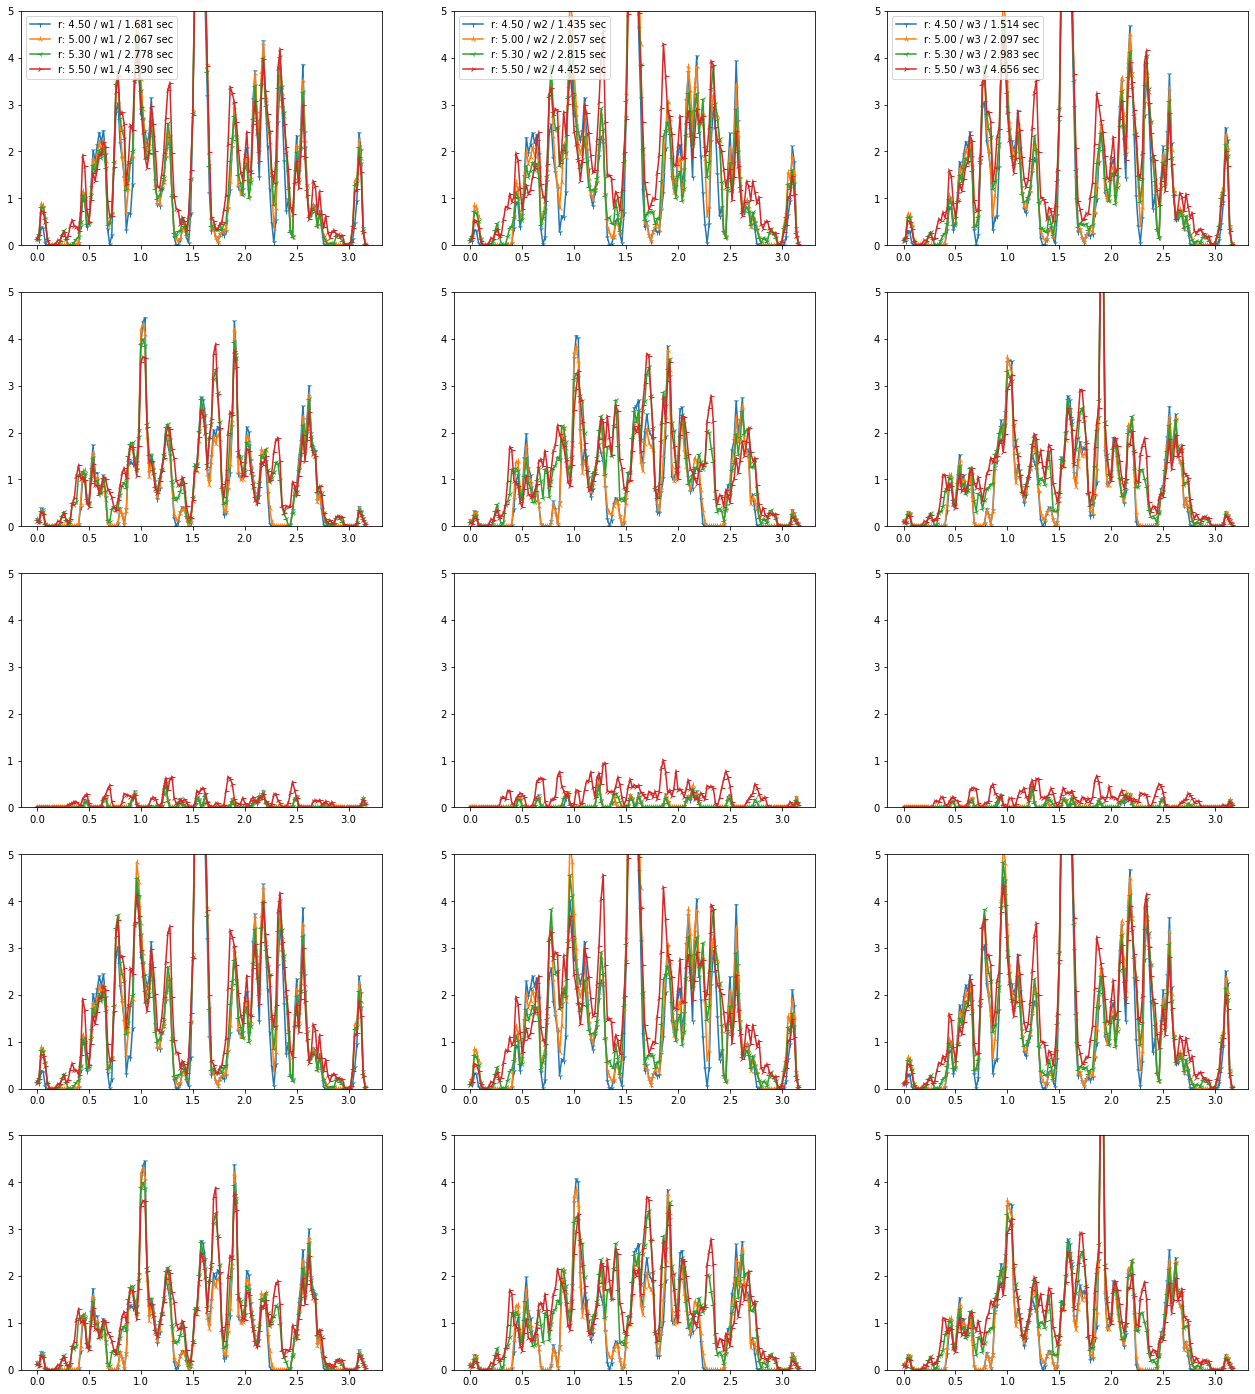

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

f, axs = plt.subplots(5, 3, figsize=(22,25))
x = bgd.filter

for j, (rmax, m) in enumerate(zip([4.5, 5, 5.3, 5.5], ['1','2','3','4'])):
    nbr = crys.get_all_neighbors(rmax, include_index=True)
    y1, t1 = by_mat1(nbr)
    y2, t2 = by_mat2(nbr)
    y3, t3 = by_mat3(nbr)

    for i, ax in enumerate(axs):
        ax[0].plot(x, y1[i]/np.std(y1), marker=m, label='r: {:.2f} / w1 / {:.3f} sec'.format(rmax, t1))
        ax[1].plot(x, y2[i]/np.std(y2), marker=m, label='r: {:.2f} / w2 / {:.3f} sec'.format(rmax, t2))
        ax[2].plot(x, y3[i]/np.std(y3), marker=m, label='r: {:.2f} / w3 / {:.3f} sec'.format(rmax, t3))
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        if i == 0:
            axs[i,j].legend(loc='upper left')
        axs[i,j].set_ylim([0,5])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


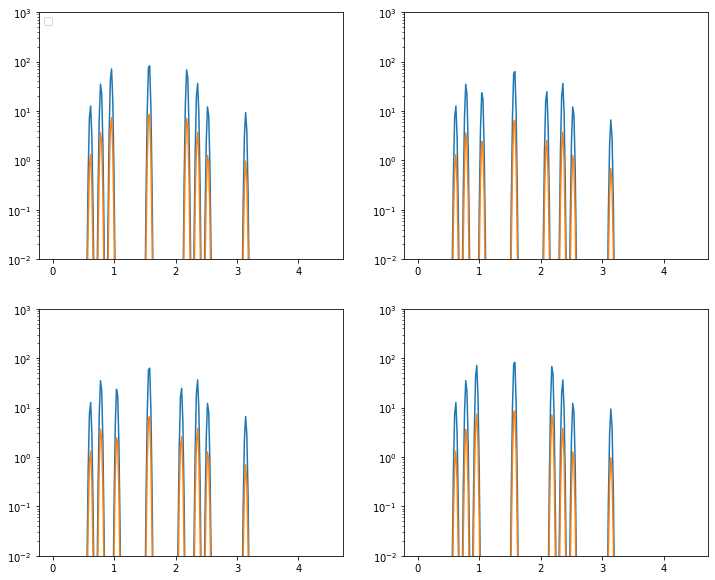

In [57]:
import matplotlib.pyplot as plt
from nm.util.math import GaussianDistance
%matplotlib inline

f, axs = plt.subplots(2, 2, figsize=(12,10))
axs = axs.reshape(-1)
x = dataset.bgd.filter

for i, ax in enumerate(axs):
    ax.plot(x, bdfs[i])
#    ax.plot(x, scaled[i])
    ax.plot(x, bdfs[i]/np.std(bdfs))
    ax.set_yscale('log')
    ax.set_ylim([1e-2, 1e3])
axs[0].legend(loc='upper left')

### Dataset object

In [41]:

class TESTDataSet:
    def __init__(self, rb_max, dt):
        self.rb_max = rb_max
        self.dt = dt
        self.n_bdf_feature = int(3.15/self.dt) + 1

    def _angle(self, v_i, v_j, radian=True, axis=-1):
        '''
    calculate angle between two vectors 'v_i' and 'v_j' 
    using numpy.arccos

    Args:
        v_i (vector): Vector from origin
        v_j (vector): Vector from origin

    Returns:
        Angle
        '''
        vi = v_i/np.expand_dims(np.linalg.norm(v_i, axis=axis), axis)
        vj = v_j/np.expand_dims(np.linalg.norm(v_j, axis=axis), axis)
        
        dot = np.expand_dims(np.sum(vi*vj, axis=axis), axis)
        dot[dot >  1]  = 1
        dot[dot < -1] = -1
        rad = np.arccos(dot)
        if radian: 
            return rad
        return rad*180.0/np.pi

    def get_bdf_by_one(self, fn):
        crys = Structure.from_file(fn)
        t1 = time.time()
        return self._get_bdf(crys), '{:.3f} sec'.format(time.time() - t1)

    def get_bdf_by_mat(self, fn):
        crys = Structure.from_file(fn)
        t1 = time.time()
        return self._mat_bdf(crys), '{:.3f} sec'.format(time.time() - t1)

    def _i_bdf(self, v1, v2):
        return (self._angle(v1, v2, radian=True)/self.dt).astype(int)

    def _w_bdf(self, r):
        return np.min([np.ones(r.shape), 28/(r**3 + 1)], keepdims=True)

    def _get_bdf(self, crys):
        atomic_numbers = crys.atomic_numbers
        element = sorted(set(atomic_numbers))
        map_element = [element.index(an) for an in atomic_numbers]
        bdf_feature = np.zeros((len(element)*len(atomic_numbers), self.n_bdf_feature), dtype=float)
        all_nbrs = crys.get_all_neighbors(self.rb_max, include_index=True)

        for i, nbrs in enumerate(all_nbrs):
            c_i = crys[i].coords
            for nj, nbr_j in enumerate(nbrs):
                c_j, r_j, j = nbr_j[0:3]
                idx_atom1 = i*len(element) + map_element[j]
                v1 = c_j.coords - c_i

                for nk, nbr_k in enumerate(nbrs):
                    if nj == nk: continue
                    c_k, r_k, k = nbr_k[0:3]
                    idx_atom2 = i*len(element) + map_element[k]
                    v2 = c_k.coords - c_i
                    idx_bdf = self._i_bdf(v1, v2)
                    bdf_feature[idx_atom1, idx_bdf] += self._w_bdf(np.max(r_j))
                    bdf_feature[idx_atom2, idx_bdf] += self._w_bdf(np.max(r_k))
            return bdf_feature
    
    def _mat_bdf(self, crys):
        atomic_numbers = crys.atomic_numbers
        element = sorted(set(atomic_numbers))
        map_element = [element.index(an) for an in atomic_numbers]
        bdf_feature = np.zeros((len(element)*len(atomic_numbers), self.n_bdf_feature), dtype=float)
        all_nbrs = crys.get_all_neighbors(self.rb_max, include_index=True)

        for i, nbrs in enumerate(all_nbrs):
            c_i = crys[i].coords
            for nj, nbr_j in enumerate(nbrs):
                c_j, r_j, j = nbr_j[0:3]
                ij = i*len(element) + map_element[j]
                wj = self._w_bdf(r_j)
                v = c_j.coords - c_i

                v2  = np.array([nbr_k[0].coords for nk, nbr_k in enumerate(nbrs) if nk != nj]) - c_i
                v1  = np.tile(v, v2.shape[:-1] + (1,))
#                wks = self._w_bdf(np.array([nbr_k[1] for nk, nbr_k in enumerate(nbrs) if nk != nj]))
#                iks = [i*len(element) + map_element[nbr_k[2]] for nk, nbr_k in enumerate(nbrs) if nk != nj]
                ibs = self._i_bdf(v1, v2)

#                for ik, ib, wk in zip(iks, ibs, wks):
#                    bdf_feature[ij, ib] += wj
#                    bdf_feature[ik, ib] += wk

        return bdf_feature
#                for nk, nbr_k in enumerate(nbrs):
#                    if nj == nk: continue
#                    c_k, r_k, k = nbr_k[0:3]
#                    idx_atom2 = i*len(element) + map_element[k]
#                    v2 = c_k.coords - c_i
#                    idx_bdf = self._i_bdf(v1, v2)
#                    bdf_feature[idx_atom1, idx_bdf] += self._w_bdf(r_j)
#                    bdf_feature[idx_atom2, idx_bdf] += self._w_bdf(r_k)
#            return bdf_feature

In [35]:
test = TESTDataSet(rb_max=8, dt=0.1)
_, t = test.get_bdf_by_one('c:/WORKSPACE_KRICT/DATA/data_snu/poscar/icsd-67560.poscar')
print(t)

2.240 sec


In [42]:
test = TESTDataSet(rb_max=8, dt=0.1)
_, t = test.get_bdf_by_mat('c:/WORKSPACE_KRICT/DATA/data_snu/poscar/icsd-67560.poscar')
print(t)

7.045 sec


In [26]:
a = np.tile([1,0], (10,1))
b = np.array([[2*np.cos(t), 2*np.sin(t)] for t in np.linspace(0,3.14,10)])

#a, b = [1.5, 0], [0, 2]

na = np.expand_dims(np.linalg.norm(a, axis=-1), -1)
nb = np.expand_dims(np.linalg.norm(b, axis=-1), -1)

xa = a/na
xb = b/nb
c = np.sum((a/na) * (b/nb), axis=-1)
c[c>1] = 1
c[c<-1] = -1
c

array([ 1.        ,  0.93975313,  0.76627189,  0.50045969,  0.17434523,
       -0.17277674, -0.4990802 , -0.76524761, -0.93920748, -0.99999873])

In [54]:
m = torch.nn.BatchNorm1d(100)
input = torch.randn(20, 100)
output = m(input)
output.shape

torch.Size([20, 100])

In [101]:
w = np.tile(np.linspace(0, 0.0017,18).reshape(-1,1), (1,5))
mat_atom_feature = torch.tensor(np.array([[i+j/10 for j in range(5)] for i in range(7)]))
atom_feature1 = mat_atom_feature[[5, 5, 5, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]] + w
atom_feature2 = mat_atom_feature[[5, 2, 1]*6] + w
atom_idx = torch.tensor([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5])
ele_idx  = torch.tensor([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2])

In [111]:
#atom_feature1, global_mean_pool(atom_feature1, atom_idx)#[atom_idx],
#atom_feature2, 
global_mean_pool(atom_feature2, ele_idx)[ele_idx],


(tensor([[5.0008, 5.1007, 5.2008, 5.3007, 5.4007],
         [2.0009, 2.1008, 2.2009, 2.3009, 2.4008],
         [1.0010, 1.1010, 1.2009, 1.3010, 1.4009],
         [5.0008, 5.1007, 5.2008, 5.3007, 5.4007],
         [2.0009, 2.1008, 2.2009, 2.3009, 2.4008],
         [1.0010, 1.1010, 1.2009, 1.3010, 1.4009],
         [5.0008, 5.1007, 5.2008, 5.3007, 5.4007],
         [2.0009, 2.1008, 2.2009, 2.3009, 2.4008],
         [1.0010, 1.1010, 1.2009, 1.3010, 1.4009],
         [5.0008, 5.1007, 5.2008, 5.3007, 5.4007],
         [2.0009, 2.1008, 2.2009, 2.3009, 2.4008],
         [1.0010, 1.1010, 1.2009, 1.3010, 1.4009],
         [5.0008, 5.1007, 5.2008, 5.3007, 5.4007],
         [2.0009, 2.1008, 2.2009, 2.3009, 2.4008],
         [1.0010, 1.1010, 1.2009, 1.3010, 1.4009],
         [5.0008, 5.1007, 5.2008, 5.3007, 5.4007],
         [2.0009, 2.1008, 2.2009, 2.3009, 2.4008],
         [1.0010, 1.1010, 1.2009, 1.3010, 1.4009]], dtype=torch.float64),)

In [138]:
h = torch.cat(
    [
        global_mean_pool(atom_feature1, atom_idx)[atom_idx],
        global_mean_pool(atom_feature2, ele_idx)[ele_idx]
    ], dim=1
).float()

fc = torch.nn.Linear(10, 24)
bn = torch.nn.BatchNorm1d(24)
bn2 = torch.nn.BatchNorm1d(10)

In [139]:
fc_out = fc(h)
bn_out = bn(fc_out)
bn2_out = bn2(h)

In [148]:
i = 1
h[i], bn2_out[i], fc_out[i], bn_out[i]

(tensor([5.0001, 5.1001, 5.2001, 5.3001, 5.4001, 2.0008, 2.1009, 2.2009, 2.3008,
         2.4009]),
 tensor([ 2.1653,  2.1653,  2.1653,  2.1653,  2.1653, -0.3922, -0.3922, -0.3922,
         -0.3922, -0.3922], grad_fn=<SelectBackward0>),
 tensor([-0.9678,  2.1474,  2.0650,  6.2366,  1.3694,  1.4719,  2.0516,  3.1489,
         -2.8740,  1.0244,  0.5373,  0.3503,  1.3031, -2.5309, -1.9432,  1.2905,
          4.7629,  1.6556,  4.0578,  0.9496,  0.7980,  0.8445,  1.2717,  0.8698],
        grad_fn=<SelectBackward0>),
 tensor([ 0.3476,  0.4062,  1.8407,  1.1540,  0.9807,  0.4654,  2.1576,  0.6869,
         -0.1596, -0.0475, -0.9039, -0.6780,  2.1742, -0.2584, -0.0773,  0.8832,
          1.8694, -0.0952,  0.0237,  1.4639, -0.4772,  2.2003,  1.9856,  0.0070],
        grad_fn=<SelectBackward0>))

#### loss

In [47]:

cri = torch.nn.L1Loss(reduction='none')


y    = torch.tensor([0, 1, 2, 3], dtype=torch.float).view(-1,1)
pred = torch.tensor([0, 3, 1, 3], dtype=torch.float).view(-1,1)

loss = cri(pred, y).detach()
loss

tensor([[0.],
        [2.],
        [1.],
        [0.]])

In [49]:
10**(loss - 3)

tensor([[0.0010],
        [0.1000],
        [0.0100],
        [0.0010]])

#### HIOP Dataset

In [2]:
path = 'c:/WORKSPACE_KRICT/DATA/HOIP'

d = Dataset(path=path, target_idx=11, ref_idx=12, fn='hoip.csv', dtype='cif', r_max=8, dr=0.1, rb_max=5, dt=0.05)
d.generate_data()
d.save_dataset(os.path.join(path, 'dataset_large.pickle'))

  0%|          | 0/1346 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\ex01\lib\site-packages\pymatgen\io\cif.py:705: UserWarning: No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\envs\ex01\lib\site-packages\pymatgen\io\cif.py:1160: UserWarning: Issues encountered while parsing CIF: No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))
  3%|▎         | 36/1346 [01:06<33:55,  1.55s/it]C:\ProgramData\Anaconda3\envs\ex01\lib\site-packages\pymatgen\io\cif.py:1160: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".j

* Data ==============================================
   data path       : c:/WORKSPACE_KRICT/DATA/HOIP
   target idx      : 11
   data idx        : 12
   n_Crystals      : 1346
* Function ==========================================
   RDF r_max       : 8
   RDF d_r         : 0.1
   RDF n_features  : 80
   BDF r_max       : 5
   BDF d_theta     : 0.05
   BDF n_features  : 63
* Others ============================================
   n_atom_features : 8
   atom_features   : [
               "atomic_number",
               "period",
               "en_pauling",
               "covalent_radius_bragg",
               "electron_affinity",
               "atomic_volume",
               "atomic_weight",
               "fusion_heat"
]


#### Mendeleev table

In [17]:
tble = fetch_table('elements')
tble.keys()

Index(['annotation', 'atomic_number', 'atomic_radius', 'atomic_volume',
       'block', 'boiling_point', 'density', 'description',
       'dipole_polarizability', 'electron_affinity',
       'electronic_configuration', 'evaporation_heat', 'fusion_heat',
       'group_id', 'lattice_constant', 'lattice_structure', 'melting_point',
       'name', 'period', 'series_id', 'specific_heat', 'symbol',
       'thermal_conductivity', 'vdw_radius', 'covalent_radius_cordero',
       'covalent_radius_pyykko', 'en_pauling', 'en_allen', 'jmol_color',
       'cpk_color', 'proton_affinity', 'gas_basicity', 'heat_of_formation',
       'c6', 'covalent_radius_bragg', 'vdw_radius_bondi', 'vdw_radius_truhlar',
       'vdw_radius_rt', 'vdw_radius_batsanov', 'vdw_radius_dreiding',
       'vdw_radius_uff', 'vdw_radius_mm3', 'abundance_crust', 'abundance_sea',
       'molcas_gv_color', 'en_ghosh', 'vdw_radius_alvarez', 'c6_gb',
       'atomic_weight', 'atomic_weight_uncertainty', 'is_monoisotopic',
       'is_ra

In [19]:
i,k = 0,5
keys = list(sorted(tble.keys())[i:i+k])
feats  = 'atomic_number atomic_volume block covalent_radius_pyykko electron_affinity '
feats += 'electronic_configuration en_pauling fusion_heat metallic_radius vdw_radius_bondi period'
tble.loc[:25, ['symbol']+ feats.split()]

symbol  atomic_number  atomic_volume block  covalent_radius_pyykko  \
0       H              1          14.10     s                    32.0   
1      He              2          31.80     s                    46.0   
2      Li              3          13.10     s                   133.0   
3      Be              4           5.00     s                   102.0   
4       B              5           4.60     p                    85.0   
5       C              6           5.30     p                    75.0   
6       N              7          17.30     p                    71.0   
7       O              8          14.00     p                    63.0   
8       F              9          17.10     p                    64.0   
9      Ne             10          16.80     p                    67.0   
10     Na             11          23.70     s                   155.0   
11     Mg             12          14.00     s                   139.0   
12     Al             13          10.00     p                   126.0   
13     Si             14          12.10     p                   116.0   
14      P             15          17.00     p                   111.0   
15      S             16          15.50     p                   103.0   
16     Cl             17          18.70     p                    99.0   
17     Ar             18          24.20     p                    96.0   
18      K             19          45.30     s                   196.0   
19     Ca             20          29.90     s                   171.0   
20     Sc             21          15.00     d                   148.0   
21     Ti             22          10.60     d                   136.0   
22      V             23           8.35     d                   134.0   
23     Cr             24           7.23     d                   122.0   
24     Mn             25           7.39     d                   119.0   
25     Fe             26           7.10     d                   116.0   

    electron_affinity electronic_configuration  en_pauling  fusion_heat  \
0            0.754195                       1s        2.20        0.117   
1          -19.700000                      1s2         NaN          NaN   
2            0.618049                  [He] 2s        0.98        2.890   
3           -2.400000                 [He] 2s2        1.57       12.210   
4            0.279723              [He] 2s2 2p        2.04       23.600   
5            1.262119             [He] 2s2 2p2        2.55          NaN   
6           -1.400000             [He] 2s2 2p3        3.04          NaN   
7            1.461113             [He] 2s2 2p4        3.44          NaN   
8            3.401190             [He] 2s2 2p5        3.98        0.510   
9                 NaN             [He] 2s2 2p6         NaN          NaN   
10           0.547926                  [Ne] 3s        0.93        2.640   
11                NaN                 [Ne] 3s2        1.31        9.200   
12           0.432830              [Ne] 3s2 3p        1.61       10.750   
13           1.389521             [Ne] 3s2 3p2        1.90       50.600   
14           0.746607             [Ne] 3s2 3p3        2.19        2.510   
15           2.077104             [Ne] 3s2 3p4        2.58        1.230   
16           3.612725             [Ne] 3s2 3p5        3.16        6.410   
17         -11.500000             [Ne] 3s2 3p6         NaN          NaN   
18           0.501470                  [Ar] 4s        0.82      102.500   
19           0.024550                 [Ar] 4s2        1.00        9.200   
20           0.188000              [Ar] 3d 4s2        1.36       15.800   
21           0.079000             [Ar] 3d2 4s2        1.54       18.800   
22           0.525000             [Ar] 3d3 4s2        1.63       17.500   
23           0.666000              [Ar] 3d5 4s        1.66       21.000   
24                NaN             [Ar] 3d5 4s2        1.55       13.400   
25           0.151000             [Ar] 3d6 4s2        1.83       13.800   

    m

In [93]:
rad = np.array([tble.metallic_radius, tble.vdw_radius]).T
np.sum(np.isnan(rad), axis=1)[:100]

array([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [115]:
len(tble.block), np.sum(tble.block == 's') + np.sum(tble.block == 'p') + np.sum(tble.block == 'd') + np.sum(tble.block == 'f')

(118, 104)

In [24]:
np.array(tble[feats.split()])[0]

array([1, 14.1, 's', 32.0, 0.754195, '1s', 2.2, 0.117, nan, 120.0, 1],
      dtype=object)

In [124]:
for i, config in tble.electronic_configuration.iteritems():
    print(i, config)

0 1s
1 1s2
2 [He] 2s
3 [He] 2s2
4 [He] 2s2 2p
5 [He] 2s2 2p2
6 [He] 2s2 2p3
7 [He] 2s2 2p4
8 [He] 2s2 2p5
9 [He] 2s2 2p6
10 [Ne] 3s
11 [Ne] 3s2
12 [Ne] 3s2 3p
13 [Ne] 3s2 3p2
14 [Ne] 3s2 3p3
15 [Ne] 3s2 3p4
16 [Ne] 3s2 3p5
17 [Ne] 3s2 3p6
18 [Ar] 4s
19 [Ar] 4s2
20 [Ar] 3d 4s2
21 [Ar] 3d2 4s2
22 [Ar] 3d3 4s2
23 [Ar] 3d5 4s
24 [Ar] 3d5 4s2
25 [Ar] 3d6 4s2
26 [Ar] 3d7 4s2
27 [Ar] 3d8 4s2
28 [Ar] 3d10 4s
29 [Ar] 3d10 4s2
30 [Ar] 3d10 4s2 4p
31 [Ar] 3d10 4s2 4p2
32 [Ar] 3d10 4s2 4p3
33 [Ar] 3d10 4s2 4p4
34 [Ar] 3d10 4s2 4p5
35 [Ar] 3d10 4s2 4p6
36 [Kr] 5s
37 [Kr] 5s2
38 [Kr] 4d 5s2
39 [Kr] 4d2 5s2
40 [Kr] 4d4 5s
41 [Kr] 4d5 5s
42 [Kr] 4d5 5s2
43 [Kr] 4d7 5s
44 [Kr] 4d8 5s
45 [Kr] 4d10
46 [Kr] 4d10 5s
47 [Kr] 4d10 5s2
48 [Kr] 4d10 5s2 5p
49 [Kr] 4d10 5s2 5p2
50 [Kr] 4d10 5s2 5p3
51 [Kr] 4d10 5s2 5p4
52 [Kr] 4d10 5s2 5p5
53 [Kr] 4d10 5s2 5p6
54 [Xe] 6s
55 [Xe] 6s2
56 [Xe] 5d 6s2
57 [Xe] 4f 5d 6s2
58 [Xe] 4f3 6s2
59 [Xe] 4f4 6s2
60 [Xe] 4f5 6s2
61 [Xe] 4f6 6s2
62 [Xe] 4f7 6s2
63 [Xe] 4f7 5d 6s

In [132]:
#tble2 = tble.copy()
tble2.pop('annotation')
tble2.keys()

Index(['atomic_number', 'atomic_radius', 'atomic_volume', 'block',
       'boiling_point', 'density', 'description', 'dipole_polarizability',
       'electron_affinity', 'evaporation_heat', 'fusion_heat', 'group_id',
       'lattice_constant', 'lattice_structure', 'melting_point', 'name',
       'period', 'series_id', 'specific_heat', 'symbol',
       'thermal_conductivity', 'vdw_radius', 'covalent_radius_cordero',
       'covalent_radius_pyykko', 'en_pauling', 'en_allen', 'jmol_color',
       'cpk_color', 'proton_affinity', 'gas_basicity', 'heat_of_formation',
       'c6', 'covalent_radius_bragg', 'vdw_radius_bondi', 'vdw_radius_truhlar',
       'vdw_radius_rt', 'vdw_radius_batsanov', 'vdw_radius_dreiding',
       'vdw_radius_uff', 'vdw_radius_mm3', 'abundance_crust', 'abundance_sea',
       'molcas_gv_color', 'en_ghosh', 'vdw_radius_alvarez', 'c6_gb',
       'atomic_weight', 'atomic_weight_uncertainty', 'is_monoisotopic',
       'is_radioactive', 'cas', 'atomic_radius_rahm', 'geochem

In [141]:
for i, (p, ec) in tble[['period','electronic_configuration']].iterrows():
    print(i, p, ec.split()[0])

0 1 1s
1 1 1s2
2 2 [He]
3 2 [He]
4 2 [He]
5 2 [He]
6 2 [He]
7 2 [He]
8 2 [He]
9 2 [He]
10 3 [Ne]
11 3 [Ne]
12 3 [Ne]
13 3 [Ne]
14 3 [Ne]
15 3 [Ne]
16 3 [Ne]
17 3 [Ne]
18 4 [Ar]
19 4 [Ar]
20 4 [Ar]
21 4 [Ar]
22 4 [Ar]
23 4 [Ar]
24 4 [Ar]
25 4 [Ar]
26 4 [Ar]
27 4 [Ar]
28 4 [Ar]
29 4 [Ar]
30 4 [Ar]
31 4 [Ar]
32 4 [Ar]
33 4 [Ar]
34 4 [Ar]
35 4 [Ar]
36 5 [Kr]
37 5 [Kr]
38 5 [Kr]
39 5 [Kr]
40 5 [Kr]
41 5 [Kr]
42 5 [Kr]
43 5 [Kr]
44 5 [Kr]
45 5 [Kr]
46 5 [Kr]
47 5 [Kr]
48 5 [Kr]
49 5 [Kr]
50 5 [Kr]
51 5 [Kr]
52 5 [Kr]
53 5 [Kr]
54 6 [Xe]
55 6 [Xe]
56 6 [Xe]
57 6 [Xe]
58 6 [Xe]
59 6 [Xe]
60 6 [Xe]
61 6 [Xe]
62 6 [Xe]
63 6 [Xe]
64 6 [Xe]
65 6 [Xe]
66 6 [Xe]
67 6 [Xe]
68 6 [Xe]
69 6 [Xe]
70 6 [Xe]
71 6 [Xe]
72 6 [Xe]
73 6 [Xe]
74 6 [Xe]
75 6 [Xe]
76 6 [Xe]
77 6 [Xe]
78 6 [Xe]
79 6 [Xe]
80 6 [Xe]
81 6 [Xe]
82 6 [Xe]
83 6 [Xe]
84 6 [Xe]
85 6 [Xe]
86 7 [Rn]
87 7 [Rn]
88 7 [Rn]
89 7 [Rn]
90 7 [Rn]
91 7 [Rn]
92 7 [Rn]
93 7 [Rn]
94 7 [Rn]
95 7 [Rn]
96 7 [Rn]
97 7 [Rn]
98 7 [Rn]
99 7 [Rn]
100 7 [Rn]
10

In [30]:
ds = pickle.load(open('C:/WORKSPACE_KRICT/DATA/data_snu/inputdata_scale_orig_TFF.pickle','rb'))
atom_feats = {i:list() for i in range(99)}
rdf_feats = {i:list() for i in range(99)}
bdf_feats = {i:list() for i in range(99)}
gga_vals = {i:list() for i in range(99)}
hse_vals = {i:list() for i in range(99)}

for cry in tqdm(ds.crystal, total=len(ds.crystal)):
    atoms = cry.atom_feature.numpy()
    rdfs = cry.rdf_feature.numpy()
    bdfs = cry.bdf_feature.numpy()
    idx_atom = cry.idx_atom.numpy()
    idx_ele  = cry.idx_element.numpy()
    element  = cry.element
    hse = cry.target.numpy()
    gga = cry.ref.numpy()
    if hse < 0 or gga < 0: continue
    i = len(element)
    n_af = atoms.shape[1]
    n_rf = rdfs.shape[1]
    n_bf = bdfs.shape[1]
    c = np.zeros((i,i,1), dtype=int)
    atom_feat = np.zeros((i, i, n_af), dtype=float)
    rdf_feat = np.zeros((i, i, n_rf), dtype=float)
    bdf_feat = np.zeros((i, i, n_bf), dtype=float)
    for atom, rdf, bdf, ia, ie in zip(atoms, rdfs, bdfs, idx_atom, idx_ele):
        atom_feat[ia,ie] += atom
        rdf_feat[ia,ie] += rdf
        bdf_feat[ia,ie] += bdf
        c[ia,ie,0] += 1
    atom_feats[i].append((atom_feat/c).reshape(-1))
    rdf_feats[i].append((rdf_feat/c).reshape(-1))
    bdf_feats[i].append((bdf_feat/c).reshape(-1))
    gga_vals[i].append(gga)
    hse_vals[i].append(hse)

atom_feats = {f'ele-{k}':np.array(v).squeeze() for k,v in atom_feats.items() if len(v) != 0}
rdf_feats = {f'ele-{k}':np.array(v).squeeze() for k,v in rdf_feats.items() if len(v) != 0}
bdf_feats = {f'ele-{k}':np.array(v).squeeze() for k,v in bdf_feats.items() if len(v) != 0}
gga_vals = {f'ele-{k}':np.array(v).reshape(-1,1) for k,v in gga_vals.items() if len(v) != 0}
hse_vals = {f'ele-{k}':np.array(v).reshape(-1,1) for k,v in hse_vals.items() if len(v) != 0}
diff_vals = {k:gga_vals[k]-hse_vals[k] for k in hse_vals.keys()}


100%|██████████| 10388/10388 [00:03<00:00, 2748.61it/s]


In [24]:
from sklearn.manifold import TSNE

def draw_tsne(features, labels, n_components=2, n_iter=1000, cmap='hot', alpha=0.5):
    vmin = -2
    vmax = 2
    f, axs = plt.subplots(len(features), len(labels), figsize=(4*len(labels), 3*len(features)))
    for i, (k, feat) in enumerate(features.items()):
        model = TSNE(n_components=n_components, init='random', learning_rate='auto', n_iter=n_iter)
        x, y  = np.array(model.fit_transform(feat)).T
        for j, (label, data) in enumerate(labels.items()):
            level = data[k]
            axs[i,j].set_title('Key:{} / Label: {}'.format(k, label))
            axs[i,j].scatter(x, y, c=np.log10(level+1e-3), cmap=cmap, alpha=alpha, vmin=vmin, vmax=vmax)
        f.colorbar(mpl.cm.ScalarMappable(norm=plt.Normalize(vmin, vmax), cmap=cmap), ax=axs[i,-1])
    return f

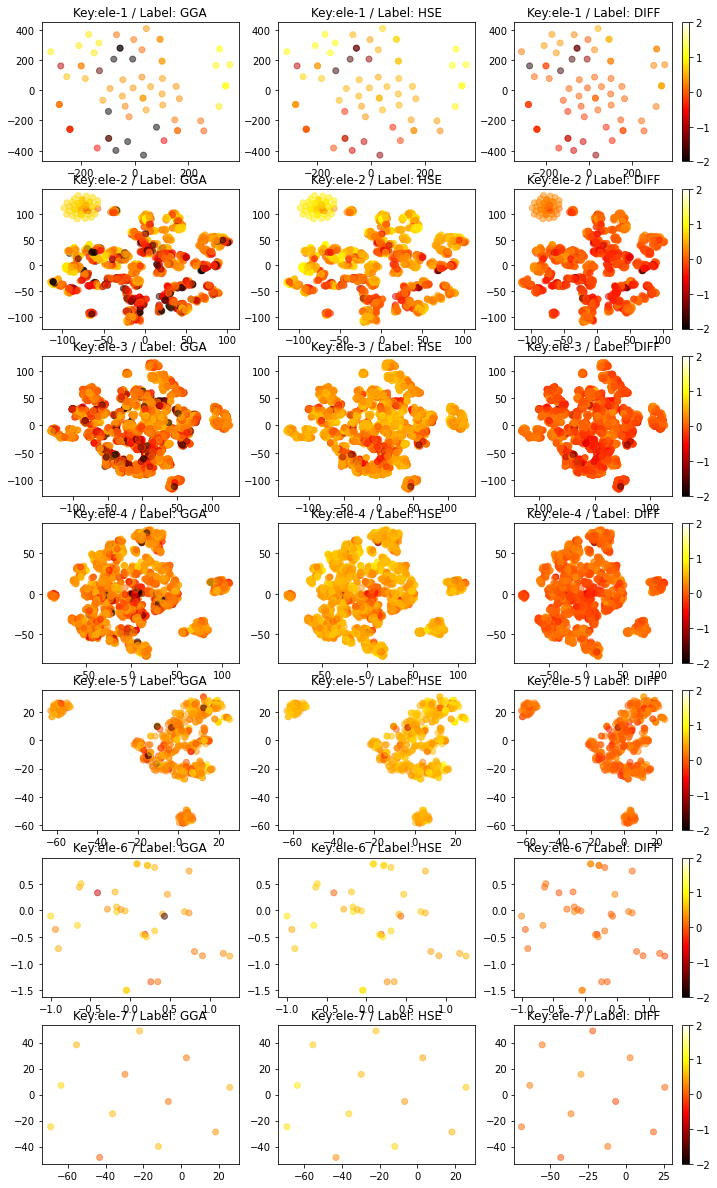

In [31]:
_ = draw_tsne(n_iter=2500,
#    features={k:np.hstack([rdf_feats[k], bdf_feats[k]]) for k in atom_feats.keys()},
    features=atom_feats,
    labels={'GGA':gga_vals, 'HSE':hse_vals, 'DIFF':{k:np.abs(v) for k,v in diff_vals.items()}}
)

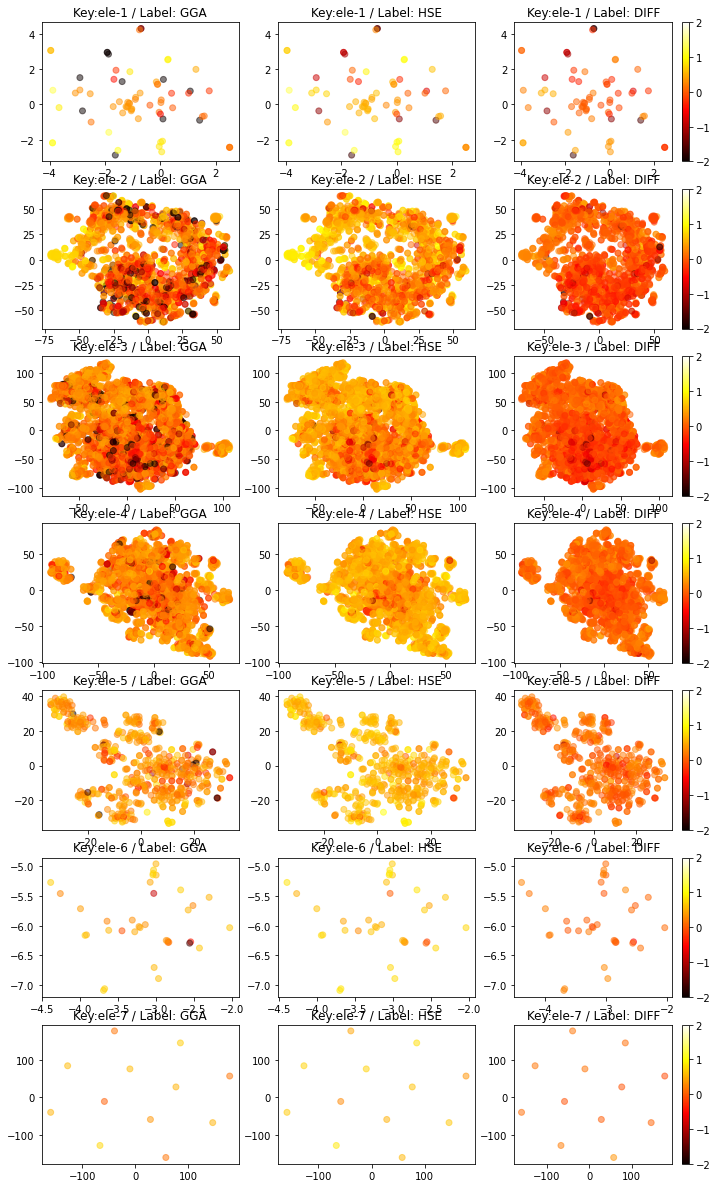

In [26]:
_ = draw_tsne(n_iter=2500,
#    features={k:np.hstack([rdf_feats[k], bdf_feats[k]]) for k in atom_feats.keys()},
    features=rdf_feats,
    labels={'GGA':gga_vals, 'HSE':hse_vals, 'DIFF':{k:np.abs(v) for k,v in diff_vals.items()}}
)

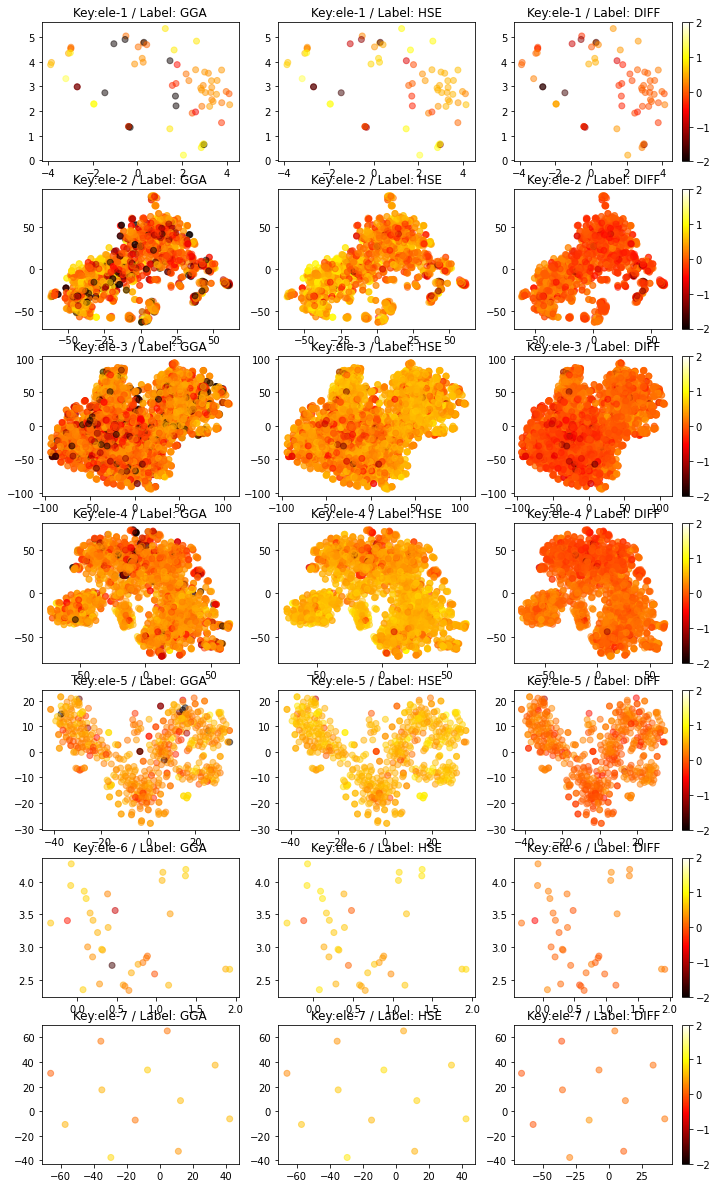

In [27]:
_ = draw_tsne(n_iter=2500,
#    features={k:np.hstack([rdf_feats[k], bdf_feats[k]]) for k in atom_feats.keys()},
    features=bdf_feats,
    labels={'GGA':gga_vals, 'HSE':hse_vals, 'DIFF':{k:np.abs(v) for k,v in diff_vals.items()}}
)

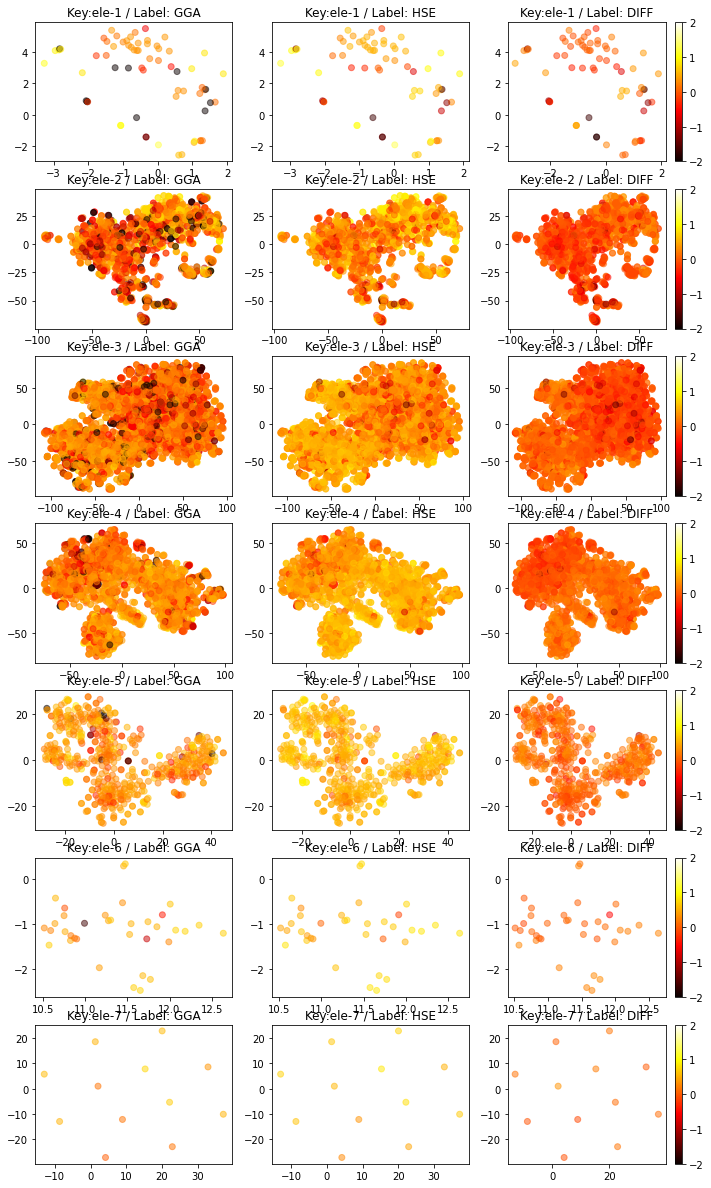

In [28]:
_ = draw_tsne(n_iter=2500,
    features={k:np.hstack([rdf_feats[k], bdf_feats[k]]) for k in atom_feats.keys()},
    labels={'GGA':gga_vals, 'HSE':hse_vals, 'DIFF':{k:np.abs(v) for k,v in diff_vals.items()}}
)

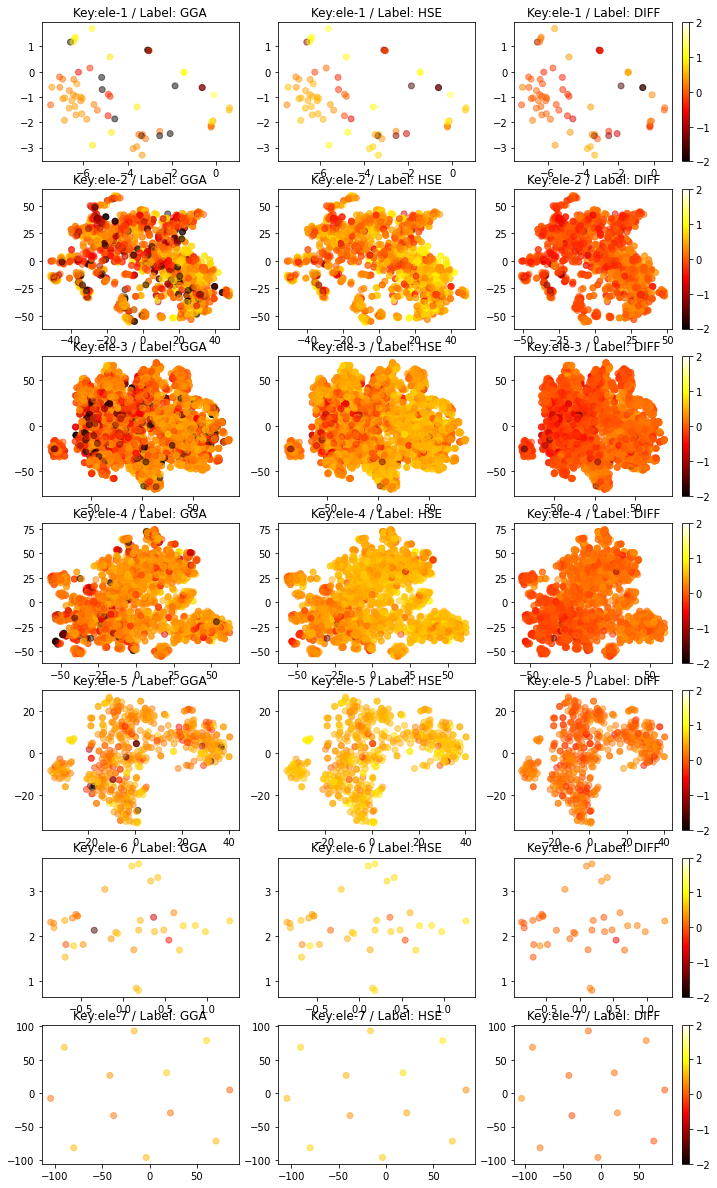

In [32]:
_ = draw_tsne(
    features={k:np.hstack([atom_feats[k], rdf_feats[k], bdf_feats[k]]) for k in atom_feats.keys()},
    labels={'GGA':gga_vals, 'HSE':hse_vals, 'DIFF':{k:np.abs(v) for k,v in diff_vals.items()}}
)

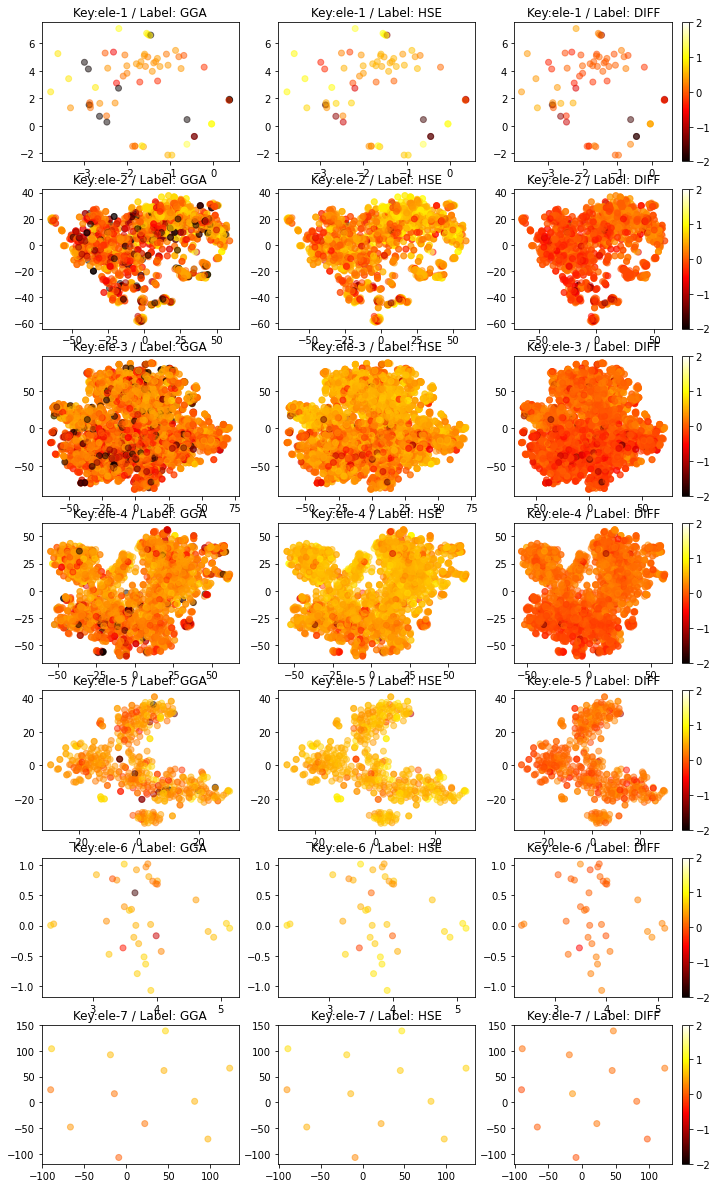

In [33]:
_ = draw_tsne(
    features={k:np.hstack([atom_feats[k]*0.5, rdf_feats[k], bdf_feats[k]]) for k in atom_feats.keys()},
    labels={'GGA':gga_vals, 'HSE':hse_vals, 'DIFF':{k:np.abs(v) for k,v in diff_vals.items()}}
)

In [7]:
from mendeleev import element

element(5).ionenergies

{1: 8.298019, 2: 25.15483, 3: 37.93058, 4: 259.3715, 5: 340.226008}